In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import math
import numpy as np

import torch


import importlib
import sys

sys.path.append('../')
sys.path.append('../../ai8x-training')

tinierssd = importlib.import_module('models.ai85net-tinierssd', package='../../ai8x-training/')

from utils import parse_sampleoutput
import parse_qat_yaml
import ai8x


## 1) Read sampleoutput.h file generated by izer:
 
 
'python ai8xize.py --test-dir sdk/Examples/MAX78000/CNN --prefix svhn_tinierssd --checkpoint-file trained/ai85-svhn-tinierssd-qat8-q.pth.tar --config-file networks/svhn-tinierssd.yaml --overlap-data --device MAX78000 --timer 0 --display-checkpoint --verbose'



In [2]:
sampleoutput_h_file_path = '../sdk/Examples/MAX78000/CNN/svhn_tinierssd/sampleoutput.h'

In [3]:
sampleoutput_h_dict = parse_sampleoutput.parse_sampleoutput_to_dictionary(sampleoutput_h_file_path)
print(sampleoutput_h_dict.__len__())

for key,values in sampleoutput_h_dict.items():
    print(key, len(values))


15
0x50403000 425
0x5040b000 425
0x50413000 425
0x5041b000 425
0x5080b000 425
0x50813000 425
0x5081b000 425
0x50c03000 425
0x50c0b000 425
0x50c13000 425
0x50c1b000 425
0x51003000 425
0x5100b000 425
0x51013000 425
0x5101b000 425


#### 1.1) Parse read memory contents to numpy arrays: Wide or non-wide outputs matter

## 2) Read sample data npy file and get output from model

#### 2.1) Load sample npy

In [4]:
sample_input_file = '../tests/sample_svhn_74.npy'
sample_input = np.load(sample_input_file)

(3, 74, 74)
int64
[-128, 77]
[-64 -61 -42]


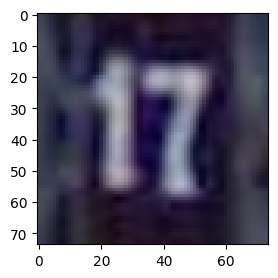

In [5]:
print(sample_input.shape)
print(sample_input.dtype)
print([sample_input.min(), sample_input.max()])
print(sample_input[:, 0, 0])

sample_input_rgb = sample_input.transpose([1, 2, 0]).astype(np.uint8) + 128
plt.figure(figsize=(3, 3))
plt.imshow(sample_input_rgb)


#### 2.2) Get output from model : Prepare Input

In [6]:

model_input = torch.FloatTensor(sample_input).unsqueeze(0)

print(model_input.shape)
print(model_input.dtype)
print(model_input.min(), model_input.max())
print(model_input[0, :, 0, 0])

torch.Size([1, 3, 74, 74])
torch.float32
tensor(-128.) tensor(77.)
tensor([-64., -61., -42.])


#### 2.2) Get output from model : Create Model

In [7]:
num_classes = 11
num_priors = 1700

In [8]:
device = "cpu"
qat_yaml_file_used_in_training = '../../ai8x-training/policies/qat_policy_svhn.yaml'
qat_policy = parse_qat_yaml.parse(qat_yaml_file_used_in_training)

checkpoint_path = '../trained/ai85-svhn-tinierssd-qat8-q.pth.tar'

ai8x.set_device(device=87, simulate=True, round_avg=True)

model = tinierssd.TinierSSD(num_classes=num_classes, device=device).to(device)

# Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
ai8x.fuse_bn_layers(model)

# Switch model from unquantized to quantized for QAT
ai8x.initiate_qat(model, qat_policy)

checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

ai8x.update_model(model)
model = model.to(device)

{'start_epoch': 25, 'weight_bits': 8, 'shift_quantile': 0.995}
Configuring device: MAX78002, simulate=True.


In [9]:
num_weights = 0
num_bias = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        if name.endswith('weight'):
            num_weights += np.prod(param.size())
        elif name.endswith('bias'):
            num_bias += np.prod(param.size())


print(f'Number of Model Weights: {num_weights}')
print(f'Number of Model Bias: {num_bias}\n')


Number of Model Weights: 335520
Number of Model Bias: 816



In [10]:
model.eval()
with torch.no_grad():
    image = model_input.to(device)
    locs, scores = model(image)
    
    print(locs.shape)
    print(locs.dtype)
    print([locs.min(), locs.max()])
    print(scores.shape)
    print(scores.dtype)
    print([scores.min(), scores.max()])


torch.Size([1, 1700, 4])
torch.float32
[tensor(-128.), tensor(127.)]
torch.Size([1, 1700, 11])
torch.float32
[tensor(-128.), tensor(127.)]


In [11]:
predicted_classes = np.argmax(scores.cpu().detach().numpy(), axis=2)
print(predicted_classes[predicted_classes > 0])

[7 7 7 7 7 7]


## 3) Compare PyTorch Output with the sampleoutput.h Contents

Highly dependent on the yaml file: networks/svhn-tinierssd.yaml

Important parts: 
* wide, non-wide outputs
* Concatenated addresses in sampleoutput.h (Check yaml for output addresses of output layers)


#### 2.1) Generate address and output information dictionary

File: networks/svhn-tinierssd.yaml
TODO: Auto parse yaml file

In [12]:
address_offset = None
wide = False
output_shape = None

output_info_dict = {}

# Layer 12: loc_conv8 (324, 16),  0x3000 - 0x3510
# Layer 13: loc_conv9 (81, 16),   0x3510 - 0x3654
# Layer 14: loc_conv10 (16, 16),   0x3654 - 0x3694
# Layer 15: loc_conv12_2 (4, 16), 0x3694 - 0x36A4
# are all concetenated using least significant 16 processors
address_offset = '0x3000'
wide = False
output_shape = (425, 16)
block_0 = (address_offset, wide, output_shape)

# Layer 16: cl_conv8 (324, 44),  0x3000 - 0x3510
# Layer 17: cl_conv9 (81, 44),   0x3510 - 0x3654
# Layer 18: cl_conv10 (16, 44),   0x3654 - 0x3694
# Layer 19: cl_conv12_2 (4, 44), 0x3694 - 0x36A4
# are all concetenated using most significant 44 processors
address_offset = '0x3000'
wide = False
output_shape = (425, 44)
block_1 = (address_offset, wide, output_shape)

# IMPORTANT: For MAX78000, not all output offsets will reside in different xxxx3000 addresses
# See: MAX78000 User Guide.pdf (https://www.analog.com/media/en/technical-documentation/user-guides/max78000-user-guide.pdf)
# xxxxB000 is also used

blocks = [block_0, block_1]

In [13]:
# TODO Take this processing into a more general form and move to parse_sampleoutput.h
# Need TODO: Add multi-pass case/s
# Need TODO: Add wide outputs

block_id = 0
read_blocks = []

# Create proper sized blocks for reading:
block = blocks[block_id]
offset = block[0]
wide = block[1]
output_shape = block[2]
read_block_0 = np.zeros(output_shape)

block_id = 1
block = blocks[block_id]
offset = block[0]
wide = block[1]
output_shape = block[2]
read_block_1 = np.zeros(output_shape)

read_blocks.append(read_block_0)
read_blocks.append(read_block_1)

# Parse sample_output_h_dict items:
block_id = 0

processor_group_idx = 0
data_idx = 0

for key, values in sampleoutput_h_dict.items():

    block = blocks[block_id]
    offset = block[0]
    wide = block[1]
    output_shape = block[2]

    num_of_channels =  output_shape[1]
    num_of_groups = math.ceil(num_of_channels / 4)

    # This if clause is true for all entries of this sample yaml
    # TODO: you may search key ends with the offset read from yamfile instead
    if key.endswith(offset[2:]) or key.endswith(hex(int(offset[2:], 16) + 0x8000)[2:]):

        if not wide:
            data_idx = 0
            
            for value in values:
                [ch0, ch1, ch2, ch3] = parse_sampleoutput.process_four_channel_data_from_word(value)

                read_blocks[block_id][data_idx, processor_group_idx * 4 + 0] = ch0 
                read_blocks[block_id][data_idx, processor_group_idx * 4 + 1] = ch1
                read_blocks[block_id][data_idx, processor_group_idx * 4 + 2] = ch2
                read_blocks[block_id][data_idx, processor_group_idx * 4 + 3] = ch3
                data_idx += 1

            processor_group_idx += 1
            data_idx = 0
            
            if processor_group_idx == num_of_groups:
                block_id += 1
                processor_group_idx = 0
        else:
            None # For processing wide outputs 

#### 2.2) Compare with PyTorch Output - Difference on Locations

True
(array([], dtype=int64), array([], dtype=int64))
0.0


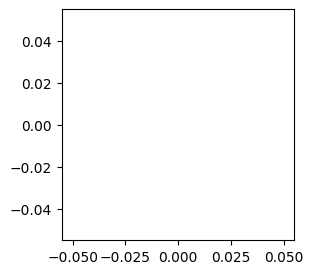

In [14]:
read_bloc_0_reshaped = read_blocks[0].reshape(-1, 4)
model_locs_np = locs.cpu().detach().numpy().squeeze(0)

# Note: as output is True, not needed to calculate and plot diff but to example:
print(np.array_equal(read_bloc_0_reshaped, model_locs_np))

non_equal_idxs = np.where(read_bloc_0_reshaped != model_locs_np)
print(non_equal_idxs)

diff = read_bloc_0_reshaped[non_equal_idxs] - model_locs_np[non_equal_idxs]
abs_diff = abs(diff)
print(np.sum(abs_diff))


plt_1 = plt.figure(figsize=(3, 3))
plt.plot(diff, marker='o')


#### 2.3) Compare with PyTorch Output - Difference on Class Scores

In [15]:
read_bloc_1_reshaped = read_blocks[1].reshape(-1, num_classes)
model_scores_np = scores.cpu().detach().numpy().squeeze(0)

# As output is True, not needed to calculate and plot diff:
print(np.array_equal(read_bloc_1_reshaped, model_scores_np))


True
